# Filtered transcriptome analysis of [*Rangaraju et al.* 2015](http://www.ncbi.nlm.nih.gov/pubmed/26623667)

Tong Shu Li

In this notebook we analyze the filtered transcriptome RNA-seq of the worms from PMID:26623667.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
sys.path.append("../..")

In [3]:
from src.plots import plot_drift
from src.plots import plot_multi_density
from src.plots import plot_p_val_heatmap

from src.stats import calc_percentile

In [4]:
%matplotlib inline

---

## Read the filtered transcriptome expression values:

In [5]:
sub = pd.read_csv("../../data/PMID26623667/avg_annotated_cpm_values.tsv", sep = '\t')

In [6]:
sub["log_cpm"] = np.log(sub["value"])

In [7]:
sub.shape

(130548, 12)

In [8]:
sub.head()

,seqname,sample,value,day_harvested,drug_conc_uM,day_drug_added,youngref,trans_drift,drug,wormbaseid,gene_symbol,log_cpm
0,2RSSE.1,1,4.105727,1,0,1,4.105726,-0.012915,water,WBGene00007064,2RSSE.1,1.412383
1,2RSSE.1,2,7.687213,3,0,1,4.105726,0.562429,water,WBGene00007064,2RSSE.1,2.039558
2,2RSSE.1,3,7.220500,5,0,1,4.105726,0.562490,water,WBGene00007064,2RSSE.1,1.976924
3,2RSSE.1,4,3.923197,10,0,1,4.105726,-0.049039,water,WBGene00007064,2RSSE.1,1.366907
4,2RSSE.1,5,4.042023,3,50,1,4.105726,-0.030335,mianserin,WBGene00007064,2RSSE.1,1.396745


---

## CPM distribution for all samples

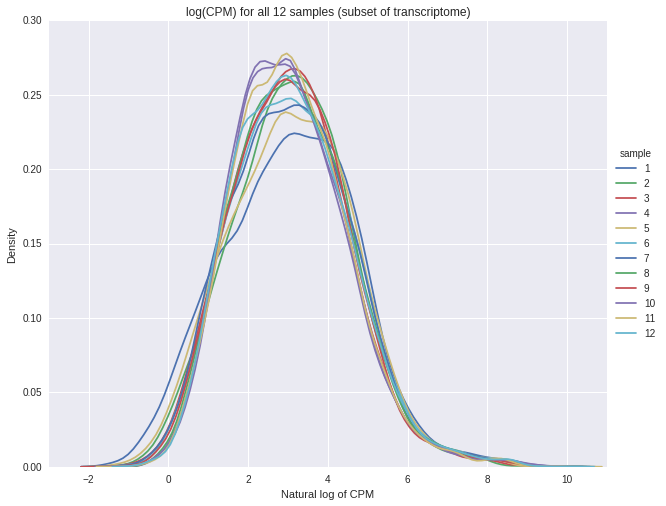

In [9]:
ax = plot_multi_density(
    sub, "sample", "log_cpm", rc = {"figure.figsize": (10, 8)}
)

ax.set_xlim((-3, 11))
ax.set_xlabel("Natural log of CPM")
ax.set_title("log(CPM) for all 12 samples (subset of transcriptome)");

The distribution of the log(CPM) for the filtered subset looks very nice. It is close to being Gaussian (except for the tail to the right). There is no hump to the left like in the full transcriptome.

## Examine drift distributions

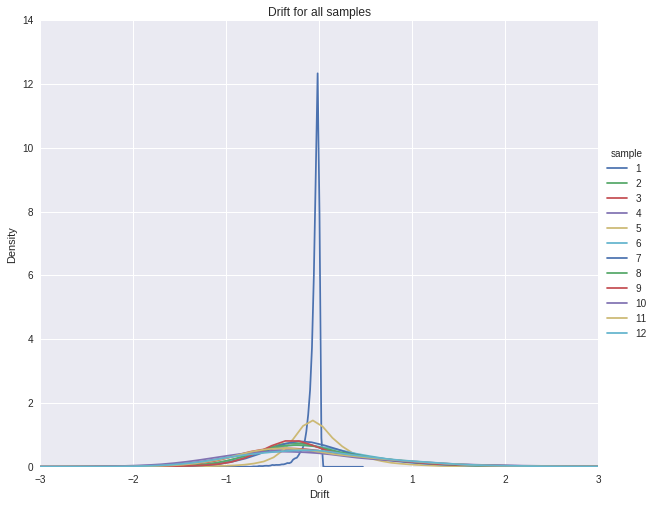

In [10]:
ax = plot_multi_density(
    sub, "sample", "trans_drift",
    rc = {"figure.figsize": (10, 8)}
)
ax.set_xlim((-3, 3))
ax.set_title("Drift for all samples")
ax.set_xlabel("Drift");

The first sample, by virtue of being the reference, has drift values which are not always exactly zero, but which is highly skewed. We will replot with sample 1 removed.

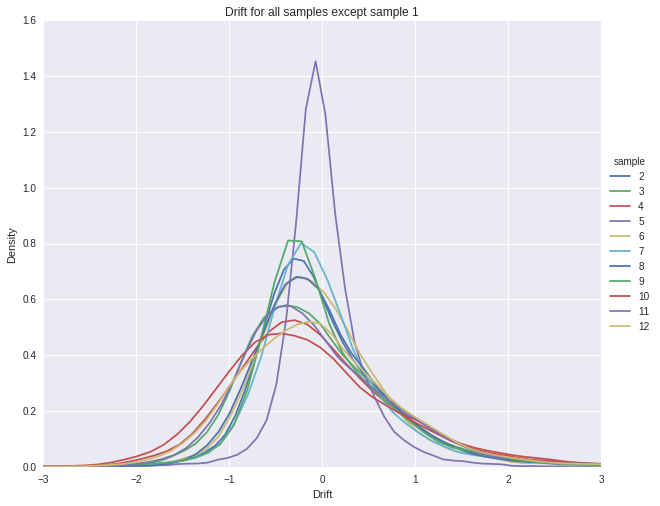

In [11]:
ax = plot_multi_density(
    sub.query("sample != 1"), "sample", "trans_drift",
    rc = {"figure.figsize": (10, 8)}
)
ax.set_xlim((-3, 3))
ax.set_title("Drift for all samples except sample 1")
ax.set_xlabel("Drift");

In all of the samples, the mean drift value seems to be slightly negative. If we replot without sample 5 (+mianserin, day 3), we see that the biggest hump disappears:

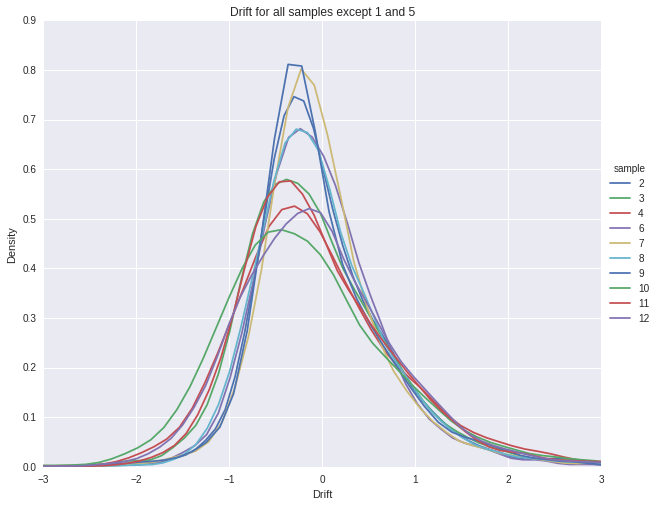

In [12]:
fig = plot_multi_density(
    sub.query("sample not in(1, 5)"), "sample", "trans_drift",
    rc = {"figure.figsize": (10, 8)}
)
fig.set_xlim((-3, 3))
fig.set_title("Drift for all samples except 1 and 5")
fig.set_xlabel("Drift");

---

## Drift as a function of expression

Since drift is defined as the log of the relative gene expression at two time points, the amount of original gene expression plays a large role in determining the magnitude of the drift. For example, a gene with a young CPM of 10000 will need to increase its expression to 20000 in order to drift 2x. However, a gene with a young CPM of 0.00001 will only need to increase expression to 0.00002 to achieve the same value of drift.

Since we can be more confident in large absolute changes in expression (easier to measure), we will need to control the drift statistic based on original expression.

### Method

1. Calculate the expression percentile for each gene
2. Examine drift as a function of the expression percentile
3. Group genes into expression deciles
4. Examine drift variance within each decile

In [13]:
ref = sub.query("sample == 1")[["wormbaseid", "log_cpm"]]

ref["exp_percentile"] = calc_percentile(ref["log_cpm"])

ref["decile"] = ref["exp_percentile"].map(
    lambda v: math.floor(v) // 10
)

ref["5_ile"] = ref["exp_percentile"].map(
    lambda v: math.floor(v) // 5
)

# ref = ref.rename(columns = {"log_cpm": "ref_log_cpm"})
ref = ref.drop("log_cpm", axis = 1)

In [14]:
sub = pd.merge(sub, ref, how = "left", on = "wormbaseid")

---

## Do genes at different original expression percentiles drift equally up and down?

### Water treated worms:

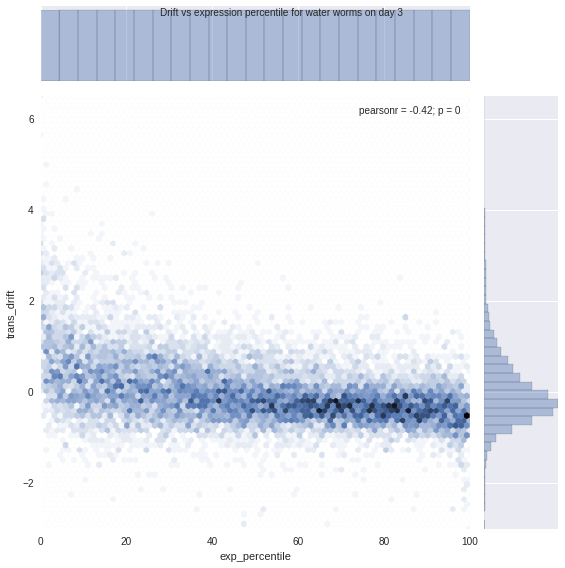

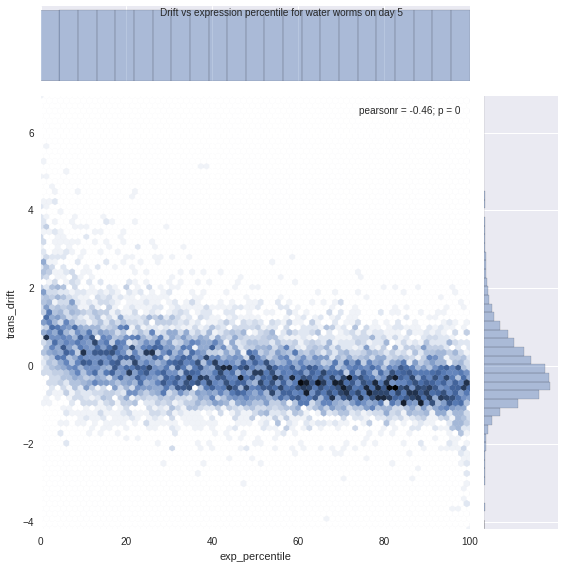

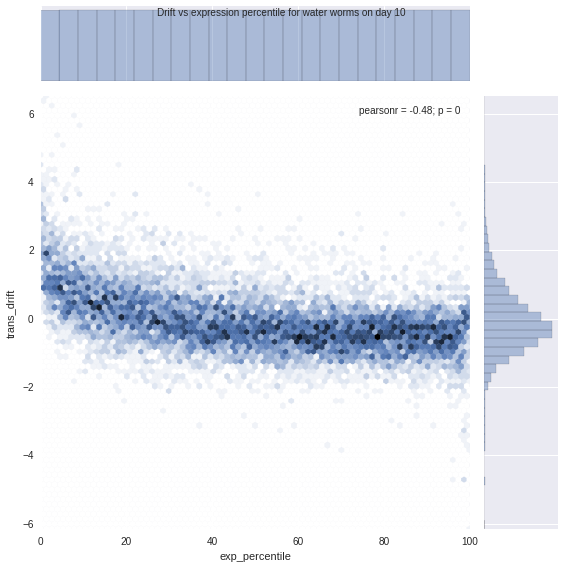

In [15]:
for key, df in sub.query("drug == 'water' & sample > 1").groupby("day_harvested"):
    ax = sns.jointplot(
        data = df,
        x = "exp_percentile",
        y = "trans_drift",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("Drift vs expression percentile for water worms on day {}".format(key))

### Mianserin treated worms:

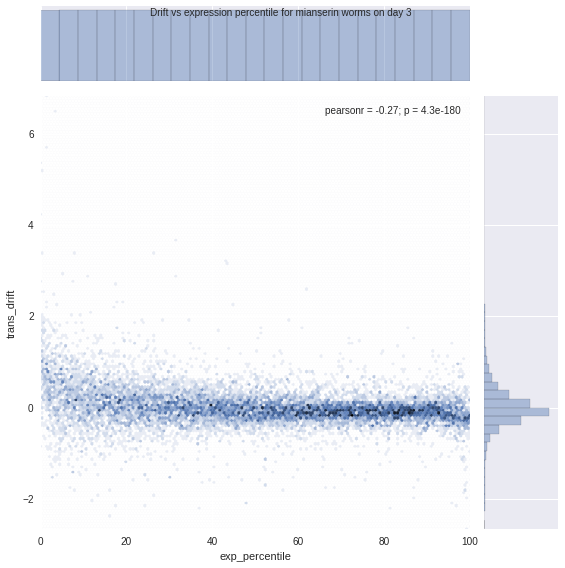

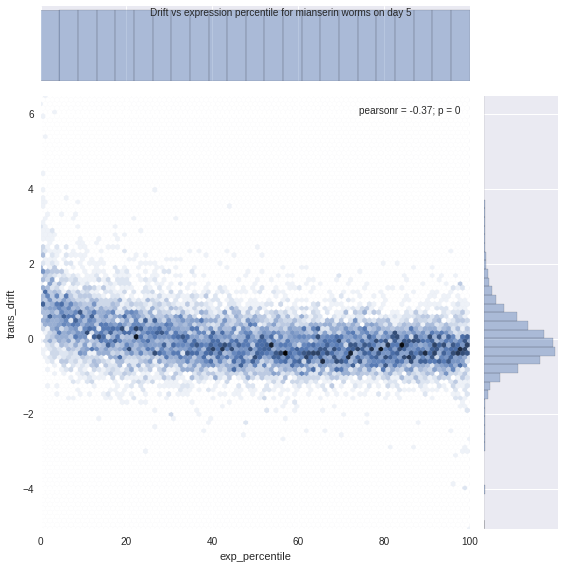

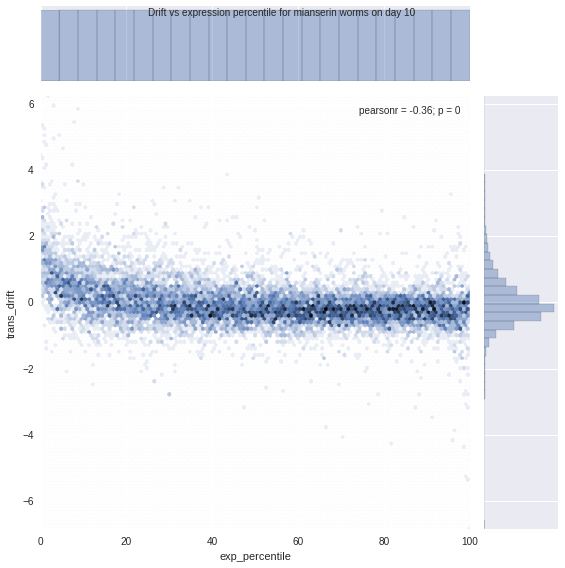

In [16]:
for key, df in sub.query("drug == 'mianserin' & sample <= 7").groupby("day_harvested"):
    ax = sns.jointplot(
        data = df,
        x = "exp_percentile",
        y = "trans_drift",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("Drift vs expression percentile for mianserin worms on day {}".format(key))

Based on the hexbin plots above, I would conclude that the original expression value of a gene does indeed affect the distribution of drift. Lower originally expressed genes cannot reduce their expression further without being removed from the dataset, and therefore the drift tends to skew upwards.

Genes which start out with a high level of expression have the freedom to increase or decrease their expression without ending at a low enough level that causes them to be removed from the dataset. Therefore as the expression percentile increases, the mean drift approaches zero.

These data suggest to me that we may want to only examine genes which start with a sufficiently high level of expression so that the resulting drift distribution is symmetrical about zero. Including the higher expressed genes (with symmetrical drift distributions) with the lower ones (biased drift distribution) results in making the drift distribution look more flattened than it really is.

---

## Drift variance as a function of original expression

What is the drift variance for each decile?

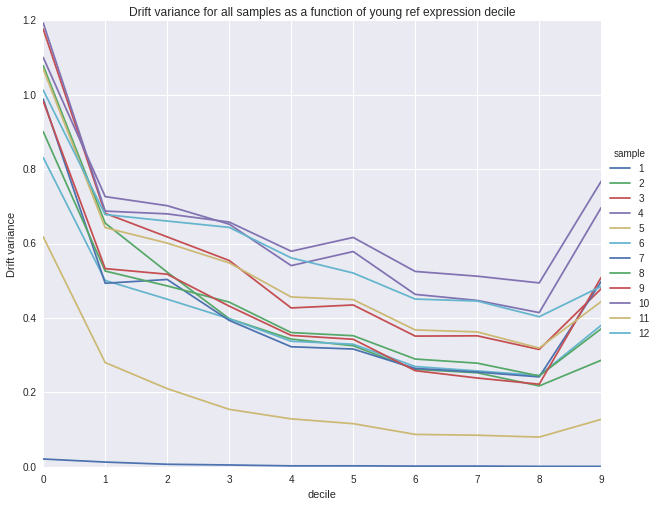

In [17]:
res = pd.DataFrame(
    [
        (sample, decile, df["trans_drift"].var())
        for (sample, decile), df in sub.groupby(["sample", "decile"])
    ],
    columns = ["sample", "decile", "drift_var"]
).pivot("decile", "sample", "drift_var")

ax = res.plot(kind = "line", figsize = (10, 8))
ax.set_title("Drift variance for all samples as a function of young ref expression decile")
ax.legend(title = "sample", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

It seems that across all the samples the drift variance linearly decreases as the original expression decile increases. We see the strange result that both the highest and lowest deciles have more drift than any other decile.

### Water treated worms

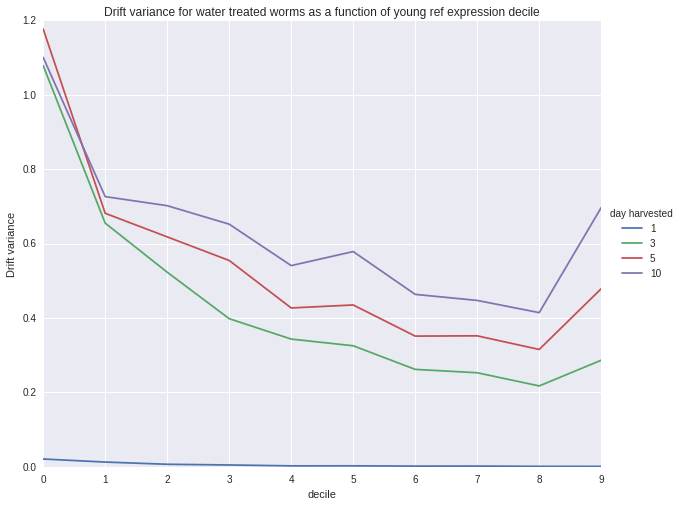

In [18]:
res = pd.DataFrame(
    [
        (day, decile, df["trans_drift"].var())
        for (day, decile), df in (sub.query("drug == 'water'")
            .groupby(["day_harvested", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", figsize = (10, 8))
ax.set_title("Drift variance for water treated worms as a function of young ref expression decile")
ax.legend(title = "day harvested", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

This plot suggests that as the worms age, the drift variance for all deciles increases equally. The ordering is also what we would expect: day 3, 5, 10 as we increase the variance. However, the days of RNA harvest are not equally spaced, but the variance increase seems to be equal.

### Mianserin treated worms

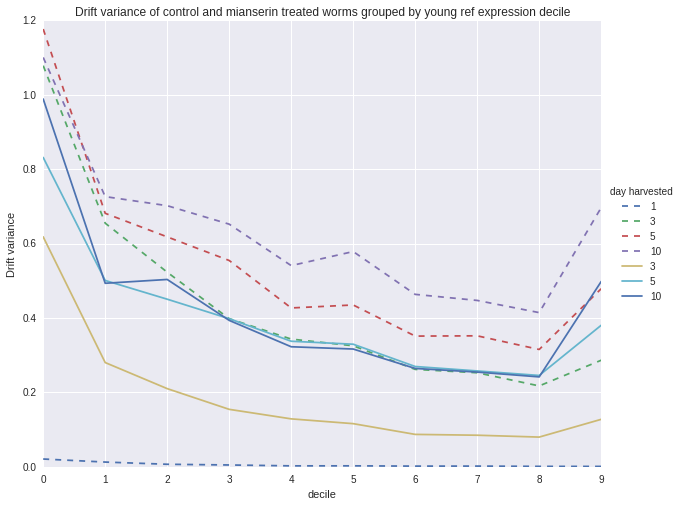

In [19]:
res = pd.DataFrame(
    [
        (day, decile, df["trans_drift"].var())
        for (day, decile), df in (sub.query("drug == 'water'")
                                  .groupby(["day_harvested", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", linestyle = "--", figsize = (10, 8))


res = pd.DataFrame(
    [
        (day, decile, df["trans_drift"].var())
        for (day, decile), df in (sub.query("drug == 'mianserin' & sample <= 7")
                                  .groupby(["day_harvested", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", linestyle = '-', ax = ax, figsize = (10, 8))

ax.set_title("Drift variance of control and mianserin treated worms grouped by young ref expression decile")

ax.legend(title = "day harvested", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

For the mianserin treated worms, the day 5 and 10 results look identical to one another. The day 3 worms have significantly less drift.

Also, in comparison to the water treated worms above, it seems that the variance is lower across all deciles when compared to the water treated worms. In actuality, the mianserin treated worms at day 5 and 10 look like the water worms at day 3.

### Plotted again but in bins of 5-percentiles

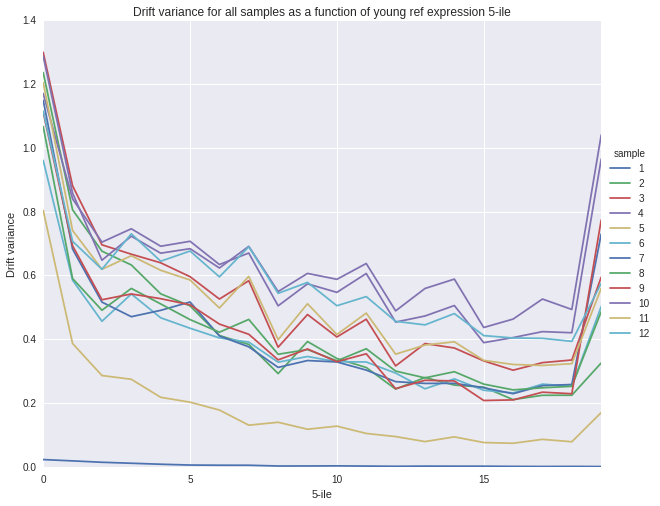

In [20]:
res = pd.DataFrame(
    [
        (sample, decile, df["trans_drift"].var())
        for (sample, decile), df in sub.groupby(["sample", "5_ile"])
    ],
    columns = ["sample", "decile", "drift_var"]
).pivot("decile", "sample", "drift_var")

ax = res.plot(kind = "line", figsize = (10, 8))
ax.set_title("Drift variance for all samples as a function of young ref expression 5-ile")
ax.legend(title = "sample", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance")
ax.set_xlabel("5-ile");

The two graphs above suggest that the drift variance is greatest at both ends of the gene expression distribution, and decreases steadily in the middle. It is expected that the variance is high for the lowly expressed genes, since small changes cause the distribution to change dramatically.

However, the fact that the very highest expressed genes also have a high drift variance is strange. Maybe this has something to do with the ability of RNA-seq to detect changes? At the extreme ends of the detection limit the machine is more likely to make errors?

In either case there seems to be a mostly linear decrease in drift variance as the percentile of the original gene expression increases. It suggests to me that the more highly expressed genes cluster more closely together, but immediate reason suggests why this should be true.

After discussing it with Michael, I will probably drop the lowest and highest 5% of expressed genes when performing further analyses.

## Drift variance for deciles over time

### Water treated worms:

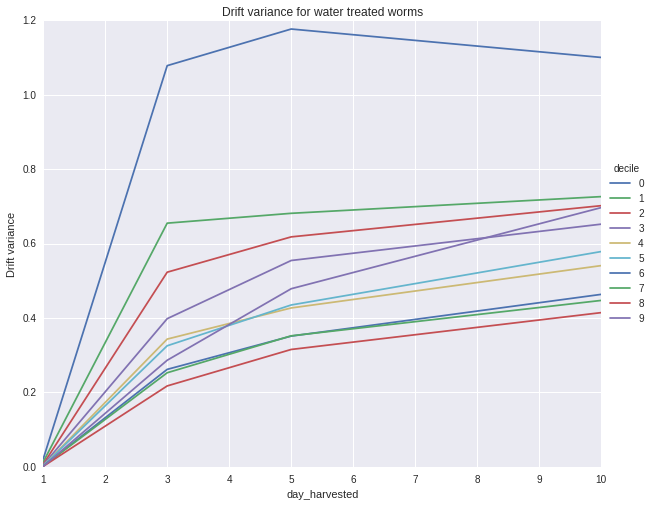

In [21]:
water_var = pd.DataFrame(
    [
        (day, decile, df["trans_drift"].var())
        for (day, decile), df in sub.query("drug == 'water'").groupby(["day_harvested", "decile"])
    ],
    columns = ["day_harvested", "decile", "drift_var"]
).pivot("day_harvested", "decile", "drift_var")

ax = water_var.plot(kind = "line", figsize = (10, 8))
ax.set_title("Drift variance for water treated worms")
ax.legend(title = "decile", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

### Mianserin treated worms

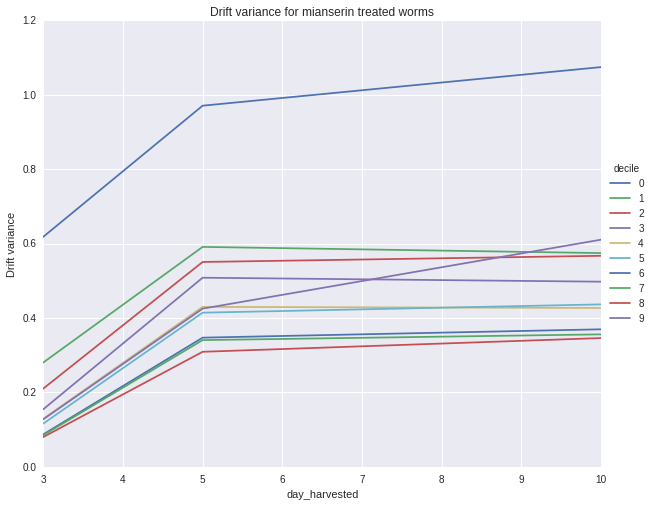

In [22]:
mianserin_var = pd.DataFrame(
    [
        (day, decile, df["trans_drift"].var())
        for (day, decile), df in sub.query("drug == 'mianserin'").groupby(["day_harvested", "decile"])
    ],
    columns = ["day_harvested", "decile", "drift_var"]
).pivot("day_harvested", "decile", "drift_var")

ax = mianserin_var.plot(kind = "line", figsize = (10, 8))
ax.set_title("Drift variance for mianserin treated worms")
ax.legend(title = "decile", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

Here again we see the expected result that the lowest decile of expressed genes seems to be a clear outlier in terms of drift variance.

However, once again we see that the most highly expressed decile of genes also increases in drift variance more rapidly with time than the middle deciles, in both the water and mianserin treated worms.

After excluding the bottom and top deciles, it seems that there is a clear linear increase in drift variance for all deciles over time. This is reduced for all deciles when mianserin is given as well.

All this seems to suggest that the bottom decile should be removed for further analysis, and perhaps the top decile as well.

---

## Plot drift for all genes in water treated worms at different days of age

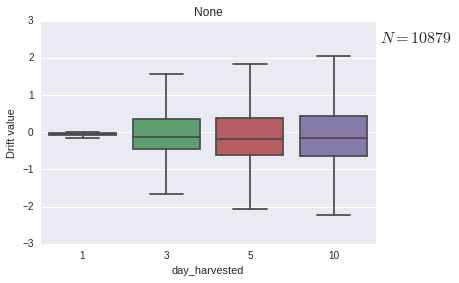

In [23]:
temp = sub.query("drug == 'water'")
                  
plot_drift(
    "box", temp,
    "day_harvested", "trans_drift", "seqname"
);

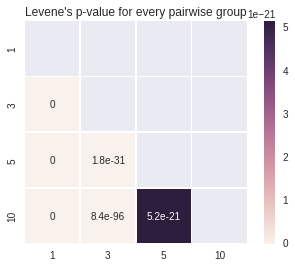

In [24]:
plot_p_val_heatmap(temp, "day_harvested", "trans_drift");

## Effect of mianserin on drift

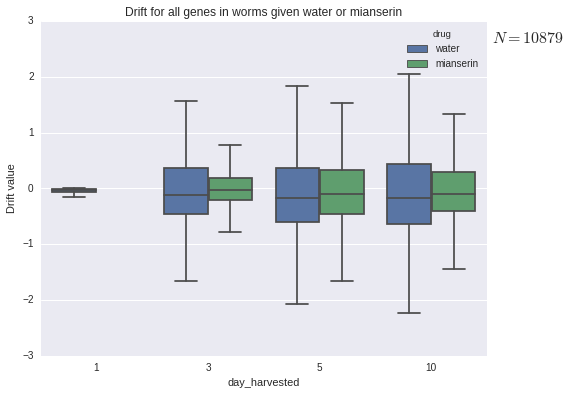

In [25]:
temp = sub.query("day_drug_added == 1 & drug_conc_uM in(0, 50)")

plot_drift(
    "box", temp, "day_harvested", "trans_drift", "seqname",
    groupby = "drug", rc = {"figure.figsize": (8, 6)},
    title = "Drift for all genes in worms given water or mianserin"
);

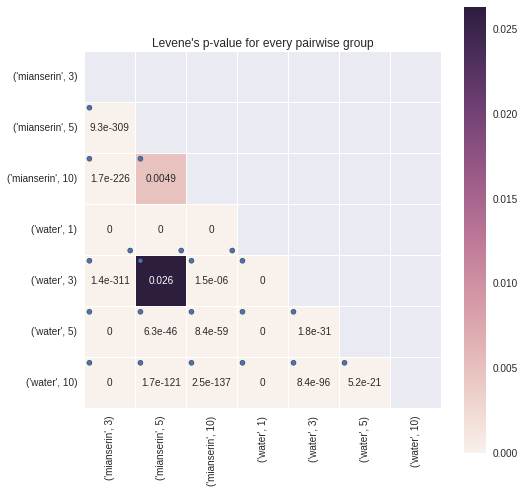

In [26]:
plot_p_val_heatmap(
    temp, ["drug", "day_harvested"], "trans_drift",
    rc = {"figure.figsize": (8, 8)}, circles = True
);